<a href="https://colab.research.google.com/github/Bharat1992/DeepLearning/blob/master/Convolutional_Model_Step_by_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks: Step by Step
Welcome to Course 4's first assignment! In this assignment, you will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and (optionally) backward propagation.

## Notation:

Superscript $[l]$ denotes an object of the $l^{th}$ layer.
Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.
Superscript $(i)$ denotes an object from the $i^{th}$ example.
Example: $x^{(i)}$ is the $i^{th}$ training example input.
Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
$n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$.
$n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$.
We assume that you are already familiar with numpy and/or have completed the previous courses of the specialization. Let's get started!

## 1 - Packages
Let's first import all the packages that you will need during this assignment.

**numpy** is the fundamental package for scientific computing with Python.
**matplotlib** is a library to plot graphs in Python.
np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) #set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# 2 - Outline of the Assignment
You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

### Convolution functions, including:
  Zero Padding
  
  Convolve window
  
  Convolution forward
  
  Convolution backward (optional)
### Pooling functions, including:
  Pooling forward
  
  Create mask
  
  Distribute value
  
  Pooling backward (optional)


This notebook will ask you to implement these functions from scratch in numpy. In the next notebook, you will use the TensorFlow equivalents of these functions to build the following model:



Note that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation.


# 3 - Convolutional Neural Networks
Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below.



In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself.

### 3.1 - Zero-Padding
Zero-padding adds zeros around the border of an image:



The main benefits of padding are the following:

-> It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer.


-> It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

Exercise: Implement the following function, which pads all the images of a batch of examples X with zeros. Use np.pad. Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with pad = 1 for the 2nd dimension, pad = 3 for the 4th dimension and pad = 0 for the rest, you would do:

a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))

In [0]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))
    ### END CODE HERE ###
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


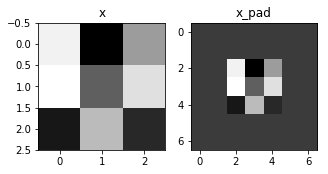

In [0]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [0]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    s = np.multiply(a_slice_prev, W) + b;
    Z = np.sum(s)
    
    return Z

In [0]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


In [0]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, nHprev, nWprev, nCPrev) = A_prev.shape
    (f, f, nCPrev, nC) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    nH = int((nHprev + 2*pad -f)/ stride + 1)
    nW = int((nWprev + 2*pad -f)/ stride + 1)
    Z = np.zeros((m, nH, nW, nC))
    
    
    AprevPad = zero_pad(A_prev, pad)
    
    for i in range(m):
      aPrevPad = AprevPad[i, :, :, :]
      for h in range(nH):
        for w in range(nW):
          for c in range(nC):
            
            vertStart = h
            vertEnd = vertStart + f
            horStart = w
            horEnd = horStart + f
            
            aSlicePrev = aPrevPad[vertStart: vertEnd, horStart: horEnd, :]
            Z[i, h, w, c] = conv_single_step(aSlicePrev, W[:, :, :, c], b[:, :, :, c])
    
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [0]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [0]:
# GRADED FUNCTION: conv_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    (m, nHprev, nWprev, nCPrev) = A_prev.shape
    
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    nH = int((nHprev - f) + 1/ stride )
    nW = int((nWprev - f) + 1/ stride )
    nC = nCPrev
    
    
    A = np.zeros((m, nH, nW, nC))
    
    for i in range(m):
      for h in range(nH):
        for w in range(nW):
          for c in range(nC):
            
            vertStart = h
            vertEnd = vertStart + f
            horStart = w
            horEnd = horStart + f
            
            aSlicePrev = A_prev[i, :, :, c]
            if mode == "max":
              A[i, h, w, c] = np.max(aSlicePrev[vertStart:vertEnd, horStart:horEnd])
            elif mode == "average":
              A[i, h, w, c] = np.mean(aSlicePrev[vertStart:vertEnd, horStart:horEnd])
    
    
    cache = (A_prev, hparameters)
    
    return A, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]
